In [1]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os
import functools

In [2]:
TE_DATA = np.linspace(8, 512, 64) #ms units

noise_opt = True
SNR_value = 100

T21_center = 50
T22_center = 70

c1 = 0.4
c2 = 0.6

T21_range = np.arange(T21_center-30, T21_center+30+.001, 1)
T22_range = np.arange(T22_center-30, T22_center+30+.001, 1)

mT21, mT22 = np.meshgrid(T21_range, T22_range)

repetitions = 1000

lamb_oi = 0.2
lamb_oi2 = 0.4

RRSS = r'RSS$^{1/2}$'
T21_label = r'$T_{21}$'
T22_label = r'$T_{22}$'
c1_label = r'$c_1$'
c2_label = r'$c_2$'
lamb_lab = r'$\lambda$'


if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

In [3]:
def G_biX(t, con_1, con_2, tau_1, tau_2): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return signal

def J_biX(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

In [4]:
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data


def format_fn(tick_val, tick_pos, labels = ""):
    if int(tick_val) < len(labels):
        return labels[int(tick_val)]
    else:
        return ''

def calculate_RSS(input, func, popt, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_regRSS(input, func, popt, lamb, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    weights = np.array([1,1,1/100,1/100])
    reg = np.sum(lamb**2 *(popt*weights)**2)
    
    return RSS+reg

# Nonregularized Case

In [5]:
true_signal = G_biX(TE_DATA, c1, c2, T21_center, T22_center)

surface_array = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        # if T21_range[iT21] <= T22_range[iT22]:
        temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_RSS(TE_DATA, G_biX, temp_param, true_signal)
        surface_array[iT22, iT21] = temp_RSS
        # else:
        #     surface_array[iT22, iT21] = np.nan

trueP_RSS = calculate_RSS(TE_DATA, G_biX, [c1, c2, T21_center, T22_center], true_signal)

In [6]:
print(f"Surface Min = {np.nanmin(surface_array)}")
print(f"Cacl Min = {trueP_RSS}")

print(f"Difference = {np.nanmin(surface_array) - trueP_RSS}")

Surface Min = 0.0
Cacl Min = 0.0
Difference = 0.0


In [7]:
minimum_T2_ind = np.zeros([repetitions, 2])
minimum_RSS = np.zeros(repetitions)
freq_array = np.zeros([len(T22_range), len(T21_range)])

all_surf_array = np.zeros([repetitions, len(T22_range), len(T21_range)])

for rep in trange(repetitions):

    noisey_sig = add_noise(true_signal, SNR_value)
    # temp_surface_array = np.zeros([len(T22_range), len(T21_range)])

    for iT21 in range(len(T21_range)):
        for iT22 in range(len(T22_range)):
            if T21_range[iT21] <= T22_range[iT22]:
                temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
                temp_RSS = calculate_RSS(TE_DATA, G_biX, temp_param, noisey_sig)
                all_surf_array[rep, iT22, iT21] = temp_RSS
            else:
                all_surf_array[rep, iT22, iT21] = np.inf

    min_indices = np.unravel_index(all_surf_array[rep,:,:].argmin(), all_surf_array[rep,:,:].shape)
    minimum_T2_ind[rep, :] = [T21_range[min_indices[1]], T22_range[min_indices[0]]]

    x_add = min_indices[0]
    y_add = min_indices[1]
    freq_array[x_add, y_add] += 1

    minimum_RSS[rep] = np.min(all_surf_array[rep,:,:])

avg_surf_array = np.mean(all_surf_array, axis = 0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]


Text(0.5, 1.0, 'True Signal for Biexponential Model\n$c_1$, $c_2$, $T_{21}$, $T_{22}$ = 0.4, 0.6, 50, 70')

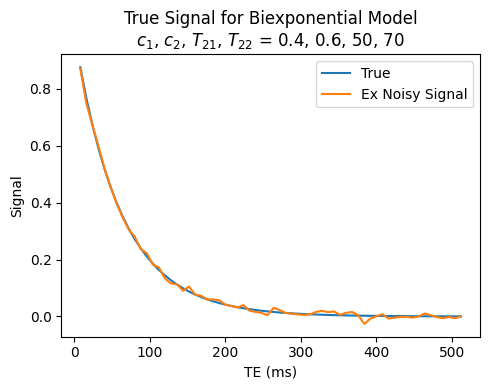

In [8]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(TE_DATA, true_signal, label = "True")
plt.plot(TE_DATA, noisey_sig, label = "Ex Noisy Signal")
plt.xlabel(r'TE (ms)')
plt.ylabel('Signal')
plt.legend()
plt.title(f'True Signal for Biexponential Model\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}')

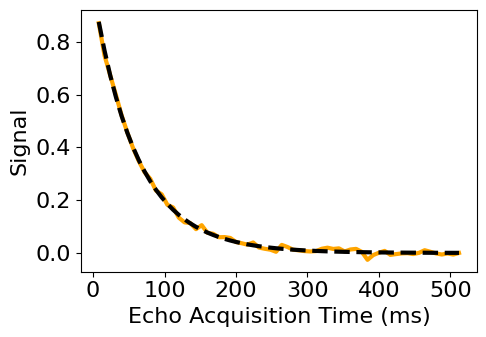

In [9]:
fig = plt.figure(figsize=(5,3.5), tight_layout=True)
plt.rc('font', size  = 16)
plt.plot(TE_DATA, noisey_sig, label = "Ex Noisy Signal", lw = 3, color = 'orange')
plt.plot(TE_DATA, true_signal, label = "True", lw = 3, ls = '--', color = 'k')
plt.xlabel(r'Echo Acquisition Time (ms)')
plt.ylabel('Signal')
# plt.legend()
# plt.title(f'True Signal for Biexponential Model\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}')
plt.rc('font', size  = 11)

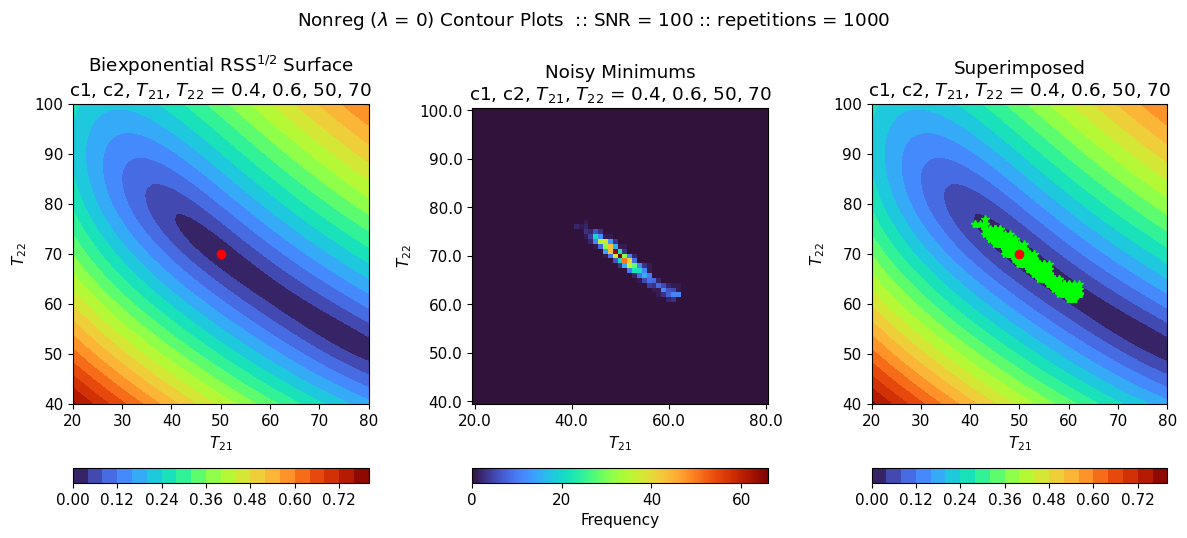

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Nonreg ({lamb_lab} = 0) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].imshow(freq_array, cmap = 'turbo', origin = 'lower')
# ax[1].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax[1].yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
# ax[1].set_ylim([np.min(T22_range), np.max(T22_range)])
# ax[1].set_xlim([np.min(T21_range), np.max(T21_range)])
ax[1].set_title(f'Noisy Minimums' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom', label = 'Frequency')

cp = ax[2].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax[2].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Superimposed' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')

# Regularized Case

In [11]:
true_signal = G_biX(TE_DATA, c1, c2, T21_center, T22_center)

surface_array_reg = np.zeros([len(T22_range), len(T21_range)])
surface_array_reg2 = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        # if T21_range[iT21] <= T22_range[iT22]:
        temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi, true_signal)
        surface_array_reg[iT22, iT21] = temp_RSS

        temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi2, true_signal)
        surface_array_reg2[iT22, iT21] = temp_RSS
        # else:
        #     surface_array_reg[iT22, iT21] = np.nan
        #     surface_array_reg2[iT22, iT21] = np.nan

trueP_regRSS = calculate_regRSS(TE_DATA, G_biX, [c1, c2, T21_center, T22_center], lamb_oi, true_signal)
trueP_regRSS2 = calculate_regRSS(TE_DATA, G_biX, [c1, c2, T21_center, T22_center], lamb_oi2, true_signal)

In [12]:
print(f"Surface Min = {np.nanmin(surface_array_reg)}")
print(f"Cacl Min = {trueP_regRSS}")

print(f"Difference = {np.nanmin(surface_array_reg) - trueP_regRSS}")

Surface Min = 0.049948139457323217
Cacl Min = 0.050400000000000014
Difference = -0.0004518605426767977


In [13]:
minimum_T2_ind_reg = np.zeros([repetitions, 2])
minimum_RSS_reg = np.zeros(repetitions)
freq_array_reg = np.zeros([len(T22_range), len(T21_range)])

all_surf_array_reg = np.zeros([repetitions, len(T22_range), len(T21_range)])

for rep in trange(repetitions):

    noisey_sig = add_noise(true_signal, SNR_value)
    # temp_surface_array = np.zeros([len(T22_range), len(T21_range)])

    for iT21 in range(len(T21_range)):
        for iT22 in range(len(T22_range)):
            if T21_range[iT21] <= T22_range[iT22]:
                temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
                temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi, noisey_sig)
                all_surf_array_reg[rep, iT22, iT21] = temp_RSS
            else:
                all_surf_array_reg[rep, iT22, iT21] = np.inf

    min_indices = np.unravel_index(all_surf_array_reg[rep, :, :].argmin(), all_surf_array_reg[rep, :, :].shape)
    minimum_T2_ind_reg[rep, :] = [T21_range[min_indices[1]], T22_range[min_indices[0]]]

    x_add = min_indices[0]
    y_add = min_indices[1]
    freq_array_reg[x_add, y_add] += 1

    minimum_RSS_reg[rep] = np.min(all_surf_array_reg[rep, :, :])


avg_surf_array_reg = np.mean(all_surf_array_reg, axis = 0)

100%|██████████| 1000/1000 [01:51<00:00,  8.96it/s]


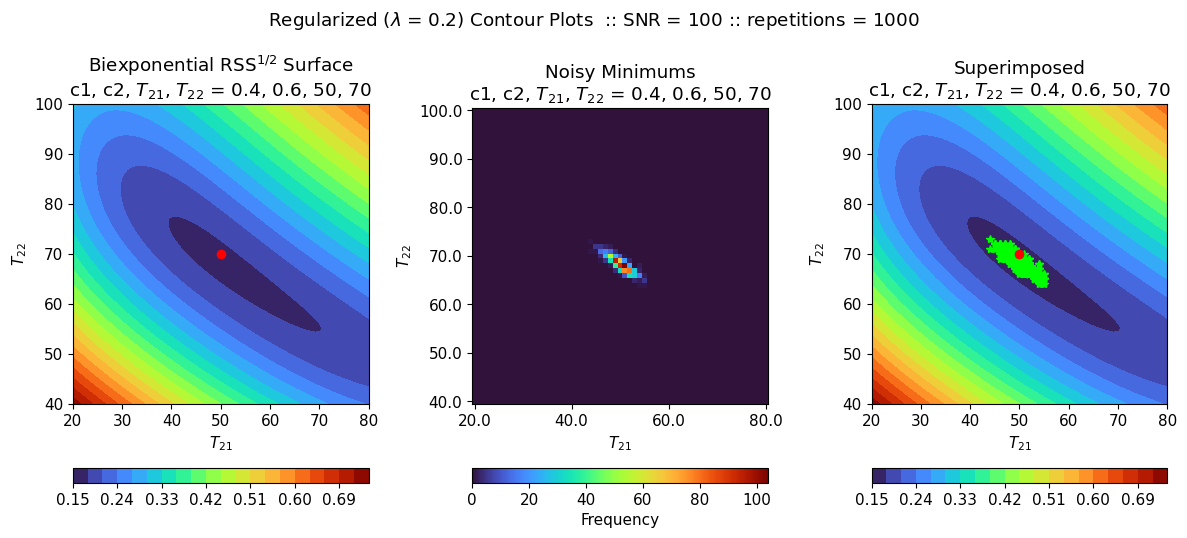

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Regularized ({lamb_lab} = {lamb_oi}) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array_reg**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS - trueP_regRSS, 20, cmap = 'turbo')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].imshow(freq_array_reg, cmap = 'turbo', origin = 'lower')
# ax[1].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax[1].yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
# ax[1].set_ylim([np.min(T22_range), np.max(T22_range)])
# ax[1].set_xlim([np.min(T21_range), np.max(T21_range)])
ax[1].set_title(f'Noisy Minimums' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom', label = 'Frequency')

cp = ax[2].contourf(mT21, mT22, rootRSS - trueP_regRSS, 20, cmap = 'turbo')
ax[2].plot(minimum_T2_ind_reg[:,0], minimum_T2_ind_reg[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Superimposed' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')

In [15]:
minimum_T2_ind_reg2 = np.zeros([repetitions, 2])
minimum_RSS_reg2 = np.zeros(repetitions)
freq_array_reg2 = np.zeros([len(T22_range), len(T21_range)])

all_surf_array_reg2 = np.zeros([repetitions, len(T22_range), len(T21_range)])

for rep in trange(repetitions):

    noisey_sig = add_noise(true_signal, SNR_value)
    # temp_surface_array = np.zeros([len(T22_range), len(T21_range)])

    for iT21 in range(len(T21_range)):
        for iT22 in range(len(T22_range)):
            if T21_range[iT21] <= T22_range[iT22]:
                temp_param = [c1, c2, T21_range[iT21], T22_range[iT22]]
                temp_RSS = calculate_regRSS(TE_DATA, G_biX, temp_param, lamb_oi2, noisey_sig)
                all_surf_array_reg2[rep, iT22, iT21] = temp_RSS
            else:
                all_surf_array_reg2[rep, iT22, iT21] = np.inf

    min_indices = np.unravel_index(all_surf_array_reg2[rep, :, :].argmin(), all_surf_array_reg2[rep, :, :].shape)
    minimum_T2_ind_reg2[rep, :] = [T21_range[min_indices[1]], T22_range[min_indices[0]]]

    x_add = min_indices[0]
    y_add = min_indices[1]
    freq_array_reg2[x_add, y_add] += 1

    minimum_RSS_reg2[rep] = np.min(all_surf_array_reg[rep, :, :])


avg_surf_array_reg2 = np.mean(all_surf_array_reg2, axis = 0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [11:37<00:00,  1.43it/s]


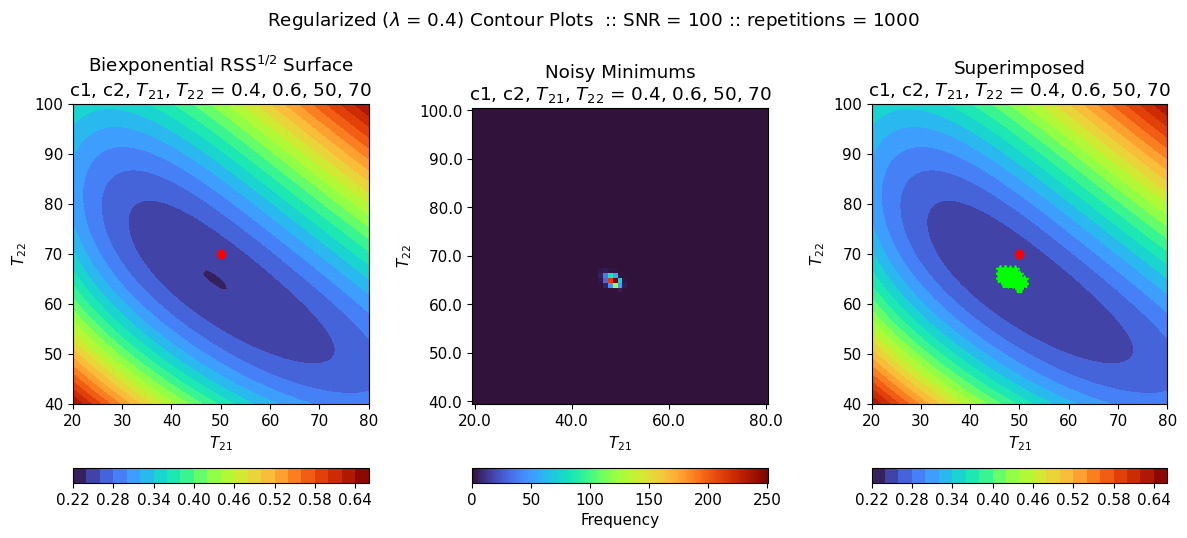

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Regularized ({lamb_lab} = {lamb_oi2}) Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = surface_array_reg2**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS - trueP_regRSS2, 20, cmap = 'turbo')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].imshow(freq_array_reg2, cmap = 'turbo', origin = 'lower')
# ax[1].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax[1].yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
# ax[1].set_ylim([np.min(T22_range), np.max(T22_range)])
# ax[1].set_xlim([np.min(T21_range), np.max(T21_range)])
ax[1].set_title(f'Noisy Minimums' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom', label = 'Frequency')

cp = ax[2].contourf(mT21, mT22, rootRSS - trueP_regRSS2, 20, cmap = 'turbo')
ax[2].plot(minimum_T2_ind_reg2[:,0], minimum_T2_ind_reg2[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Superimposed' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')

# Comparison

In [17]:
nonreg_max = np.nanmax(surface_array - np.nanmin(surface_array))
reg_max = np.nanmax(surface_array_reg - np.nanmin(surface_array_reg))

combo_max = np.max([reg_max**(1/2), nonreg_max**(1/2)])

print(combo_max)

stepsize = 0.05
bin_comp_array = np.arange(0, combo_max + stepsize, stepsize)
print(bin_comp_array)

0.7719526522674285
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8 ]


c:\co\NIA\Regularization\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\co\NIA\Regularization\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


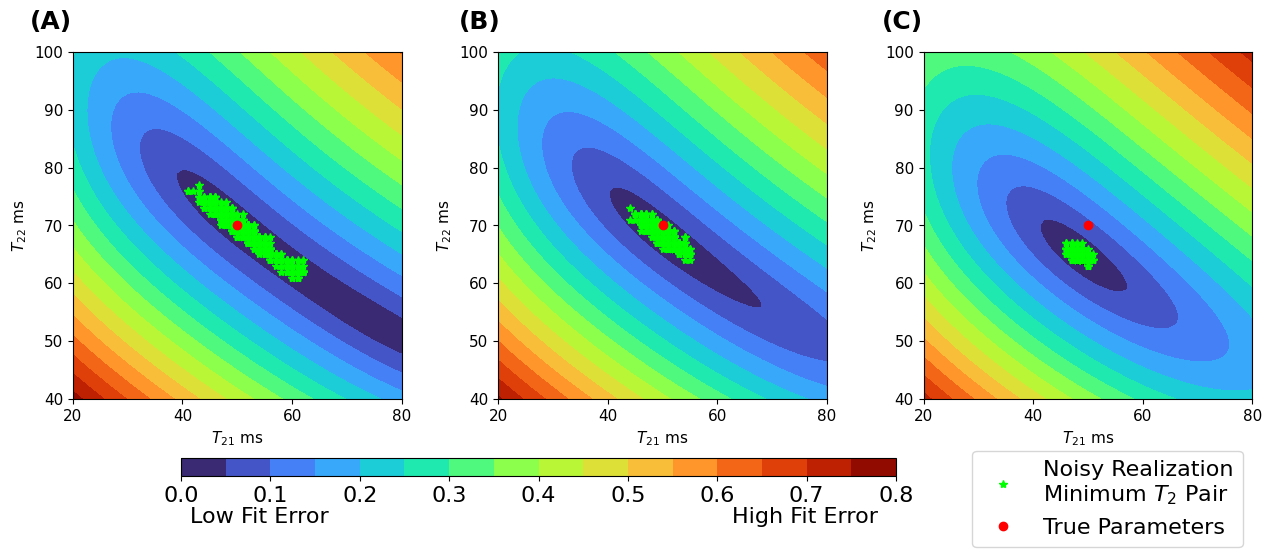

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(13,4.5), tight_layout=True)
# fig.suptitle(f" Contour Plots  :: {noise_info} :: repetitions = {repetitions}" + f"\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")

T2_text = r'$T_2$'

plt.rc('font', size = 16)

rootRSS = (surface_array - np.nanmin(surface_array))**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS, levels = bin_comp_array, cmap = 'turbo')
ax[0].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = f'Noisy Realization\nMinimum {T2_text} Pair', ls = '')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', ls = '', label = 'True Parameters')
ax[0].set_xlabel(f'{T21_label} ms')
ax[0].set_ylabel(f'{T22_label} ms')
# ax[0].set_title(f'Nonregularized ({lamb_lab} = {0})')
# fig.colorbar(cp, ax = ax[0], location = 'bottom')

rootRSS = (surface_array_reg - np.nanmin(surface_array_reg))**(1/2)
cp = ax[1].contourf(mT21, mT22, rootRSS, levels = bin_comp_array, cmap = 'turbo')
ax[1].plot(minimum_T2_ind_reg[:,0], minimum_T2_ind_reg[:,1], color = (0,1,0), marker = '*', label = f'Noisy Realization\nMinimum {T2_text} Pair', ls = '')
ax[1].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', ls = '', label = 'True Parameters')
ax[1].set_xlabel(f'{T21_label} ms')
ax[1].set_ylabel(f'{T22_label} ms')
# ax[1].set_title(f'Regularized ({lamb_lab} = {lamb_oi})')

rootRSS = (surface_array_reg2 - np.nanmin(surface_array_reg2))**(1/2)
cp = ax[2].contourf(mT21, mT22, rootRSS, levels = bin_comp_array, cmap = 'turbo')
ax[2].plot(minimum_T2_ind_reg2[:,0], minimum_T2_ind_reg2[:,1], color = (0,1,0), marker = '*', label = f'Noisy Realization\nMinimum {T2_text} Pair', ls = '')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', ls = '', label = 'True Parameters')
ax[2].set_xlabel(f'{T21_label} ms')
ax[2].set_ylabel(f'{T22_label} ms')
# ax[2].set_title(f'Regularized ({lamb_lab} = {lamb_oi2})')

plt.rc('font', size = 18)
fig.text(0.05,1, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,1, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,1, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 16)

cb_ax = fig.add_axes([0.15,-0.01,0.55,.04])
fig.colorbar(cp, ax = ax[1], orientation = 'horizontal', cax = cb_ax)
fig.text(0.21,-0.1, 'Low Fit Error', ha="center", va="center", color="black")
fig.text(0.63,-0.1, 'High Fit Error', ha="center", va="center", color="black")
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (0.75,-0.06))

In [19]:
#Need to remove the inf terms selectively

nonreg_max = np.max(avg_surf_array - np.min(avg_surf_array))
reg_max = np.max(avg_surf_array_reg - np.min(avg_surf_array_reg))

combo_max = np.max([reg_max**(1/2), nonreg_max**(1/2)])

print(combo_max)

stepsize = 0.05
bin_comp_array = np.arange(0, combo_max + stepsize, stepsize)
print(bin_comp_array)

inf


ValueError: Maximum allowed size exceeded

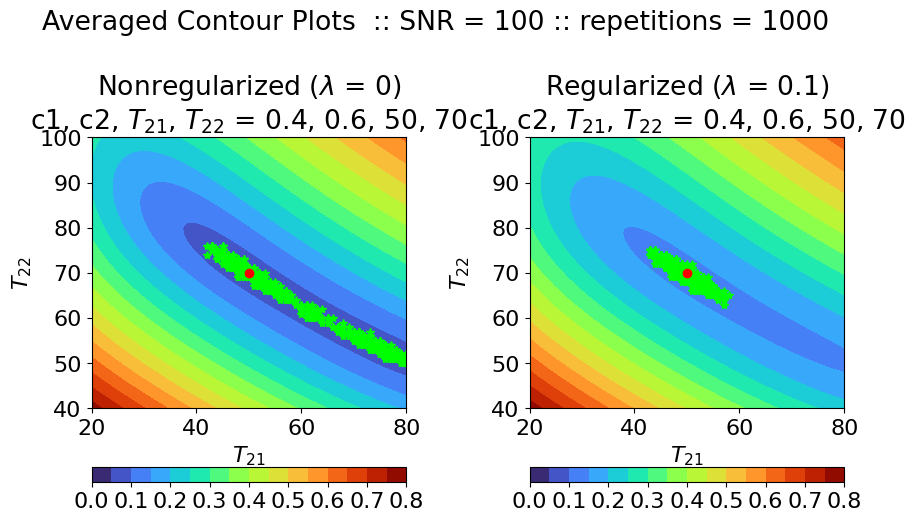

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,5.5), tight_layout=True)
fig.suptitle(f"Averaged Contour Plots  :: {noise_info} :: repetitions = {repetitions}")

rootRSS = avg_surf_array**(1/2)
cp = ax[0].contourf(mT21, mT22, rootRSS, levels = bin_comp_array, cmap = 'turbo')
ax[0].plot(minimum_T2_ind[:,0], minimum_T2_ind[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[0].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[0].set_xlabel(T21_label)
ax[0].set_ylabel(T22_label)
ax[0].set_title(f'Nonregularized ({lamb_lab} = {0})' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')

rootRSS = avg_surf_array_reg**(1/2)
cp = ax[1].contourf(mT21, mT22, rootRSS, levels = bin_comp_array, cmap = 'turbo')
ax[1].plot(minimum_T2_ind_reg[:,0], minimum_T2_ind_reg[:,1], color = (0,1,0), marker = '*', label = 'Minimum', ls = '')
ax[1].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
ax[1].set_xlabel(T21_label)
ax[1].set_ylabel(T22_label)
ax[1].set_title(f'Regularized ({lamb_lab} = {lamb_oi})' + f"\nc1, c2, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom')

# Difference in Surfaces

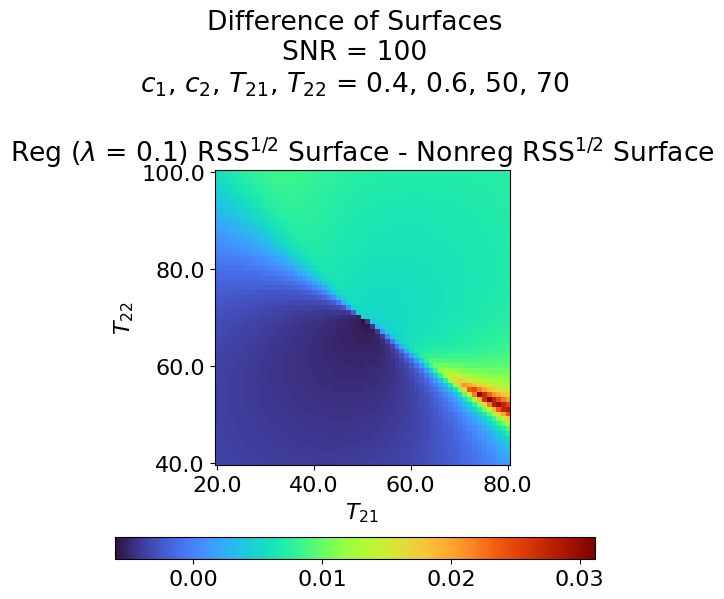

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5.5), tight_layout=True)
fig.suptitle(f"Difference of Surfaces\n{noise_info}\n{c1_label}, {c2_label}, {T21_label}, {T22_label} = {c1}, {c2}, {T21_center}, {T22_center}")

min_reg = np.min(surface_array_reg)
min_nonreg = np.min(surface_array)

diff_vals = (surface_array_reg - min_reg)**(1/2) - (surface_array - min_nonreg)**(1/2)

assert((np.min(surface_array_reg - min_reg) > 0) or (np.min(surface_array_reg - min_reg) == 0))
assert((np.min(surface_array - min_nonreg) > 0) or (np.min(surface_array - min_nonreg) == 0))

cp = ax.imshow(diff_vals, cmap = 'turbo', origin = "lower")
ax.set_xlabel(T21_label)
ax.set_ylabel(T22_label)
ax.xaxis.set_major_formatter(functools.partial(format_fn, labels = T21_range))
ax.yaxis.set_major_formatter(functools.partial(format_fn, labels = T22_range))
ax.set_title(f'Reg ({lamb_lab} = {lamb_oi}) {RRSS} Surface - Nonreg {RRSS} Surface')
cb_ax = fig.add_axes([0.1,-0.02,0.8,.04])
fig.colorbar(cp, ax = ax, orientation = 'horizontal', cax = cb_ax)